In [54]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from torchvision import transforms
import pandas as pd
import os
import matplotlib.pyplot as plt

class FractalDataset(Dataset):
    def __init__(self, image_dir, label_file, transform=None):
        self.image_dir = image_dir
        self.labels = pd.read_csv(label_file)
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.labels.iloc[idx, 0])
        image = Image.open(img_name).convert('L')  # Convert to grayscale if needed
        d_value = torch.tensor(self.labels.iloc[idx, 1], dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, d_value

class FractalCNN(nn.Module):
    def __init__(self):
        super(FractalCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.fc1 = None
        self.fc2 = nn.Linear(256, 1)

    def _initialize_fc(self, x):
        x = self.convs(x)
        flattened_size = x.view(x.size(0), -1).shape[1]
        self.fc1 = nn.Linear(flattened_size, 256)

    def convs(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv3(x))
        x = torch.max_pool2d(x, 2)
        return x

    def forward(self, x):
        if self.fc1 is None:
            self._initialize_fc(x)
        x = self.convs(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    loss_values = []  # List to store loss values

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for images, labels in train_loader:
            outputs = model(images)
            labels = labels.unsqueeze(1)  # Ensure labels match output shape
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)  # Average loss for the epoch
        loss_values.append(avg_loss)  # Store the average loss

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

    # Plot the loss function after training
    plt.plot(range(1, num_epochs + 1), loss_values, marker='o')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

Epoch [1/10], Loss: 0.8859
Epoch [2/10], Loss: 0.1938
Epoch [3/10], Loss: 0.0890
Epoch [4/10], Loss: 0.0370
Epoch [5/10], Loss: 0.0237
Epoch [6/10], Loss: 0.0158
Epoch [7/10], Loss: 0.0113
Epoch [8/10], Loss: 0.0082
Epoch [9/10], Loss: 0.0064
Epoch [10/10], Loss: 0.0057


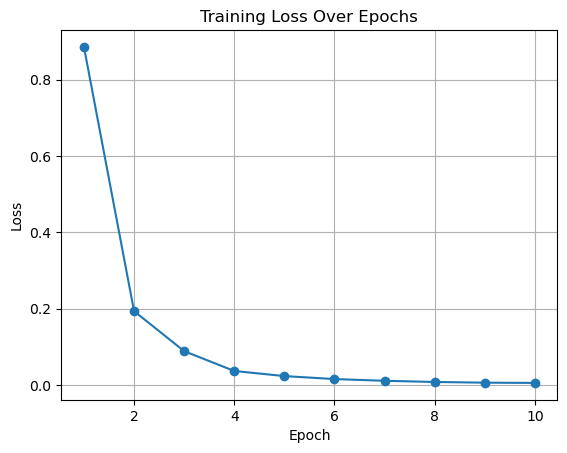

In [57]:
image_dir = r'C:\Users\absolute-zero\Desktop\fractal generation\im_out'
labels_dir = r'C:\Users\absolute-zero\Desktop\fractal generation\im_out\labels.csv'

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = FractalDataset(image_dir=image_dir, label_file=labels_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)

model = FractalCNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_model(model, train_loader, criterion, optimizer, num_epochs=10)

Average Test Loss: 0.0080
True vs Predicted D values:
True: [1.2], Predicted: [1.2639296]
True: [1.2030151], Predicted: [1.2686173]
True: [1.2060301], Predicted: [1.2880046]
True: [1.2090452], Predicted: [1.2900014]
True: [1.2120603], Predicted: [1.2235314]
True: [1.2150754], Predicted: [1.2294136]
True: [1.2180904], Predicted: [1.19958]
True: [1.2211056], Predicted: [1.258537]
True: [1.2241206], Predicted: [1.4206456]
True: [1.2271357], Predicted: [1.3697935]
True: [1.2301507], Predicted: [1.3015748]
True: [1.2331659], Predicted: [1.1818868]
True: [1.2361809], Predicted: [1.3220719]
True: [1.239196], Predicted: [1.1923772]
True: [1.2422111], Predicted: [1.3321861]
True: [1.2452261], Predicted: [1.152275]
True: [1.2482412], Predicted: [1.3212107]
True: [1.2512562], Predicted: [1.30555]
True: [1.2542714], Predicted: [1.2302424]
True: [1.2572864], Predicted: [1.4026619]
True: [1.2603015], Predicted: [1.2909782]
True: [1.2633166], Predicted: [1.2379184]
True: [1.2663317], Predicted: [1.25

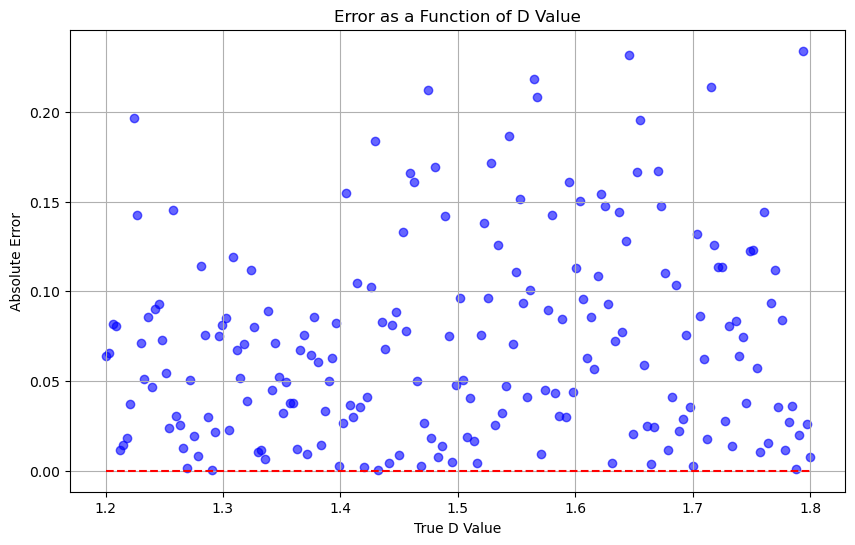

In [58]:
import torch
from torch.utils.data import DataLoader

# Assuming FractalDataset and transforms are already defined
test_image_dir = r'C:\Users\absolute-zero\Desktop\fractal generation\test_set'
test_labels_dir = r'C:\Users\absolute-zero\Desktop\fractal generation\test_set\labels.csv'

# Use the same transform as used for training
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Prepare the test dataset and DataLoader
test_dataset = FractalDataset(image_dir=test_image_dir, label_file=test_labels_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Set the model to evaluation mode
model.eval()

# Initialize variables to store test results
test_loss = 0.0
criterion = nn.MSELoss()
predictions = []
true_values = []

# Disable gradient computation for testing
with torch.no_grad():
    for images, labels in test_loader:
        # Reshape labels to match the output shape
        labels = labels.view(-1, 1)
        
        # Forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        
        # Calculate the loss
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        
        # Store predictions and true values for further analysis
        predictions.extend(outputs.cpu().numpy())
        true_values.extend(labels.cpu().numpy())


# Compute the average test loss
test_loss /= len(test_loader)
print(f'Average Test Loss: {test_loss:.4f}')

# Calculate the Mean Absolute Error (MAE)
predictions = np.array(predictions)
true_values = np.array(true_values)
mae = np.mean(np.abs(predictions - true_values))

# Print or plot the comparison
print("True vs Predicted D values:")
for true, pred in zip(true_values, predictions):
    print(f"True: {true}, Predicted: {pred}")
    
print(f'Average Deviation (MAE): {mae:.4f}')

# Calculate the error for each prediction
errors = np.abs(predictions - true_values)

# Plot error as a function of D value
plt.figure(figsize=(10, 6))
plt.scatter(true_values, errors, color='blue', alpha=0.6)
plt.plot([min(true_values), max(true_values)], [0, 0], 'r--')  # Optional: Line at zero error
plt.title('Error as a Function of D Value')
plt.xlabel('True D Value')
plt.ylabel('Absolute Error')
plt.grid(True)
plt.show()
